In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [3]:
import numpy as np
import pymc3 as pm
import exoplanet as exo
import starry
import theano
import theano.tensor as tt
np.random.seed(42)

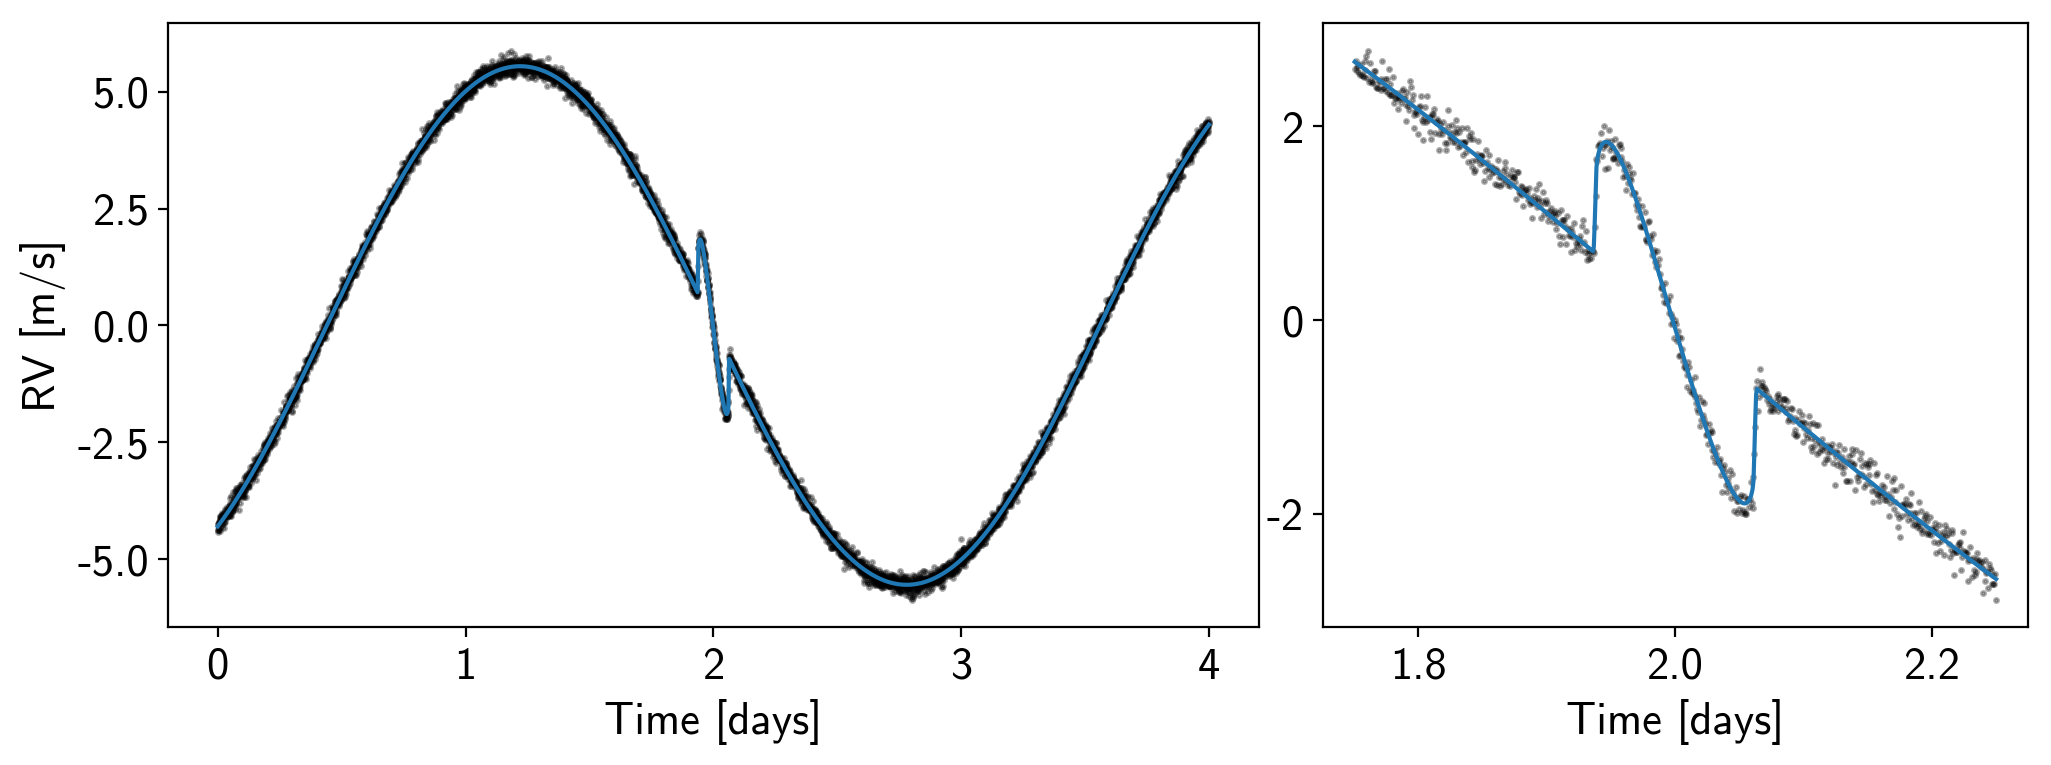

In [19]:
# True values
truths = {
    #
    # Star
    #
    "A_u":        [0.4, 0.26],
    "A_inc":      75.0,         # deg
    "A_obl":      30.0,         # deg
    "A_alpha":    0.40,
    "A_veq":      5300.0,       # m/s
    "A_m":        0.7,          # Solar
    "A_r":        1.0,          # Solar
    #
    # Planet b
    #
    "b_period":   3.12,         # days
    "b_t0":       2.00,         # days
    "b_inc":      89.5,         # deg
    "b_ecc":      0.05,
    "b_w":        70.0,         # deg
    "b_r":        0.02,         # Solar
    "b_m":        3e-5,         # Solar
    #
    # Dataset
    #
    "tstart":     0.0,          # days
    "tend":       4.0,          # days
    "tcad":       1./24./60.,   # days 
    "rv_err":     0.1           # m/s
}

# Instantiate the starry `Map`
udeg = len(truths["A_u"])
map = starry.DopplerMap(udeg=udeg)
map[1:] = truths["A_u"]
map.inc = truths["A_inc"]
map.obl = truths["A_obl"]
map.alpha = truths["A_alpha"]
map.veq = truths["A_veq"]

# Instantiate an `orbit` object
orbit = exo.orbits.KeplerianOrbit(
    period=truths["b_period"], 
    t0=truths["b_t0"], 
    incl=truths["b_inc"] * np.pi / 180.,
    m_planet=truths["b_m"],
    m_star=truths["A_m"],
    r_star=truths["A_r"]
)

# Compute the RV curve
t = np.arange(truths["tstart"], truths["tend"], truths["tcad"])
truths["rv_orbit"] = orbit.get_radial_velocity(t).eval()

# Compute the R-M signature
# To speed things up, only compute it in a window near transit,
# so we don't waste time in Theano moving zeros around. (This
# will matter a lot more when we do the sampling below.)
i_rm_min = np.argmax(t > truths["b_t0"] - 0.25)
i_rm_max = np.argmax(t > truths["b_t0"] + 0.25)
t_rm = t[i_rm_min:i_rm_max]
t_left = t[:i_rm_min]
t_right = t[i_rm_max:]
rm_model_true = map.rv_op(t=t_rm, orbit=orbit, ro=truths["b_r"] / truths["A_r"])
rm_model_true_full = tt.concatenate([tt.zeros(len(t_left)), rm_model, tt.zeros(len(t_right))])
truths["rv_rm"] = rm_model_true_full.eval()

# Join them and add noise
truths["rv"] = truths["rv_orbit"] + truths["rv_rm"]
rv = truths["rv"] + truths["rv_err"] * np.random.randn(len(t))

# Plot it
fig = plt.figure(figsize=(12, 4))
ax = [plt.subplot2grid((1, 5), (0, 0), colspan=3),
      plt.subplot2grid((1, 5), (0, 3), colspan=2)]
ax[0].plot(t, rv, 'k.', alpha=0.3, ms=3)
ax[0].set_ylim(*ax[0].get_ylim())
ax[0].plot(t, truths["rv"], label="True")
ax[0].set_xlabel("Time [days]")
ax[0].set_ylabel("RV [m/s]");

ax[1].plot(t[i_rm_min:i_rm_max], rv[i_rm_min:i_rm_max], 'k.', alpha=0.3, ms=3)
ax[1].plot(t[i_rm_min:i_rm_max], truths["rv"][i_rm_min:i_rm_max])
ax[1].set_xlabel("Time [days]");

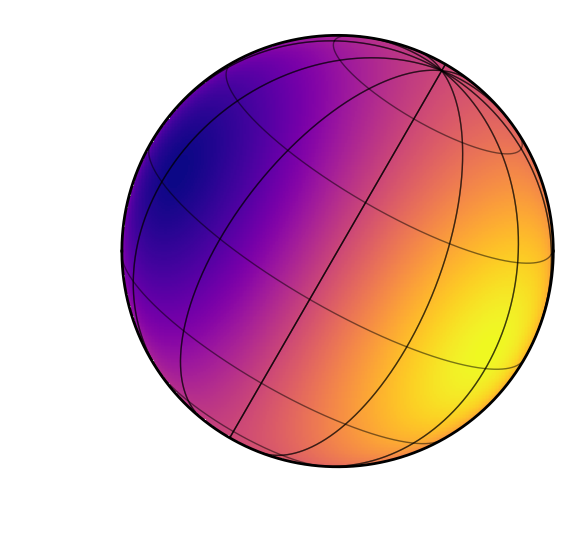

In [6]:
map.show()

In [7]:
# Define our model
map = starry.DopplerMap(udeg=udeg)
with pm.Model() as model:
    
    # Priors on stellar parameters
    A_u = exo.distributions.QuadLimbDark("A_u", testval=np.array([0.3, 0.2]))
    A_inc = pm.Uniform("A_inc", 0.0, 180.0)
    pm.Potential("A_inc_prior", pm.math.log(pm.math.sin(A_inc * np.pi / 180.0)))
    A_obl = pm.Uniform("A_obl", -180.0, 180.0)
    A_alpha = pm.Uniform("A_alpha", 0.0, 1.0)
    A_veq = pm.Uniform("A_veq", 4000.0, 6000.0)
    A_m = pm.Normal("A_m", 0.69, 0.01)
    A_r = pm.Normal("A_r", 1.01, 0.01)
    
    # Priors on planet parameters
    b_period = pm.Normal("b_period", 3.121, 0.001)
    b_t0 = pm.Normal("b_t0", 2.005, 0.01)
    b_inc = pm.Normal("b_inc", 89.55, 0.1)
    b_ecc = pm.Beta("b_ecc", 0.5, 3.0)
    b_w = pm.Uniform("b_w", 0.0, 360.0)
    b_r = pm.Normal("b_r", 0.02, 0.001)
    b_m = pm.Bound(pm.Normal, lower=0.0, upper=1.0e-4)("b_m", mu=2.0e-5, sd=2.0e-5)
    
    # Set up a Keplerian orbit for the planet
    orbit = exo.orbits.KeplerianOrbit(
        period=b_period, 
        t0=b_t0, 
        incl=b_inc * np.pi / 180.,
        m_planet=b_m,
        m_star=A_m,
        r_star=A_r
    )

    # Compute the RV curve
    orbit_model = orbit.get_radial_velocity(t)
        
    # Compute the R-M curve
    rm_model = map.rv_op(
        t=t_rm, 
        orbit=orbit, 
        u=A_u,
        inc=A_inc,
        obl=A_obl,
        alpha=A_alpha,
        veq=A_veq,
        ro=b_r / A_r
    )
    rm_model_full = tt.concatenate([tt.zeros(len(t_left)), rm_model, tt.zeros(len(t_right))])
    
    # The complete RV model is just the sum
    rv_model = orbit_model + rm_model
    
    # Here we track the value of the model light curve for plotting later
    pm.Deterministic("orbit_model", orbit_model)
    pm.Deterministic("rm_model", rm_model)
    pm.Deterministic("rv_model", rv_model)

    # Save our initial guess
    model_guess = exo.eval_in_model(rv_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=rv_model, sd=truths["rv_err"], observed=rv)

    # Fit for the maximum a posteriori parameters
    map_soln, info = exo.optimize(start=model.test_point, return_info=True)

optimizing logp for variables: ['b_m_interval__', 'b_r', 'b_w_interval__', 'b_ecc_logodds__', 'b_inc', 'b_t0', 'b_period', 'A_r', 'A_m', 'A_veq_interval__', 'A_alpha_interval__', 'A_obl_interval__', 'A_inc_interval__', 'A_u_quadlimbdark__']
message: Desired error not necessarily achieved due to precision loss.
logp: -1805687.1465121733 -> 5144.680450392322


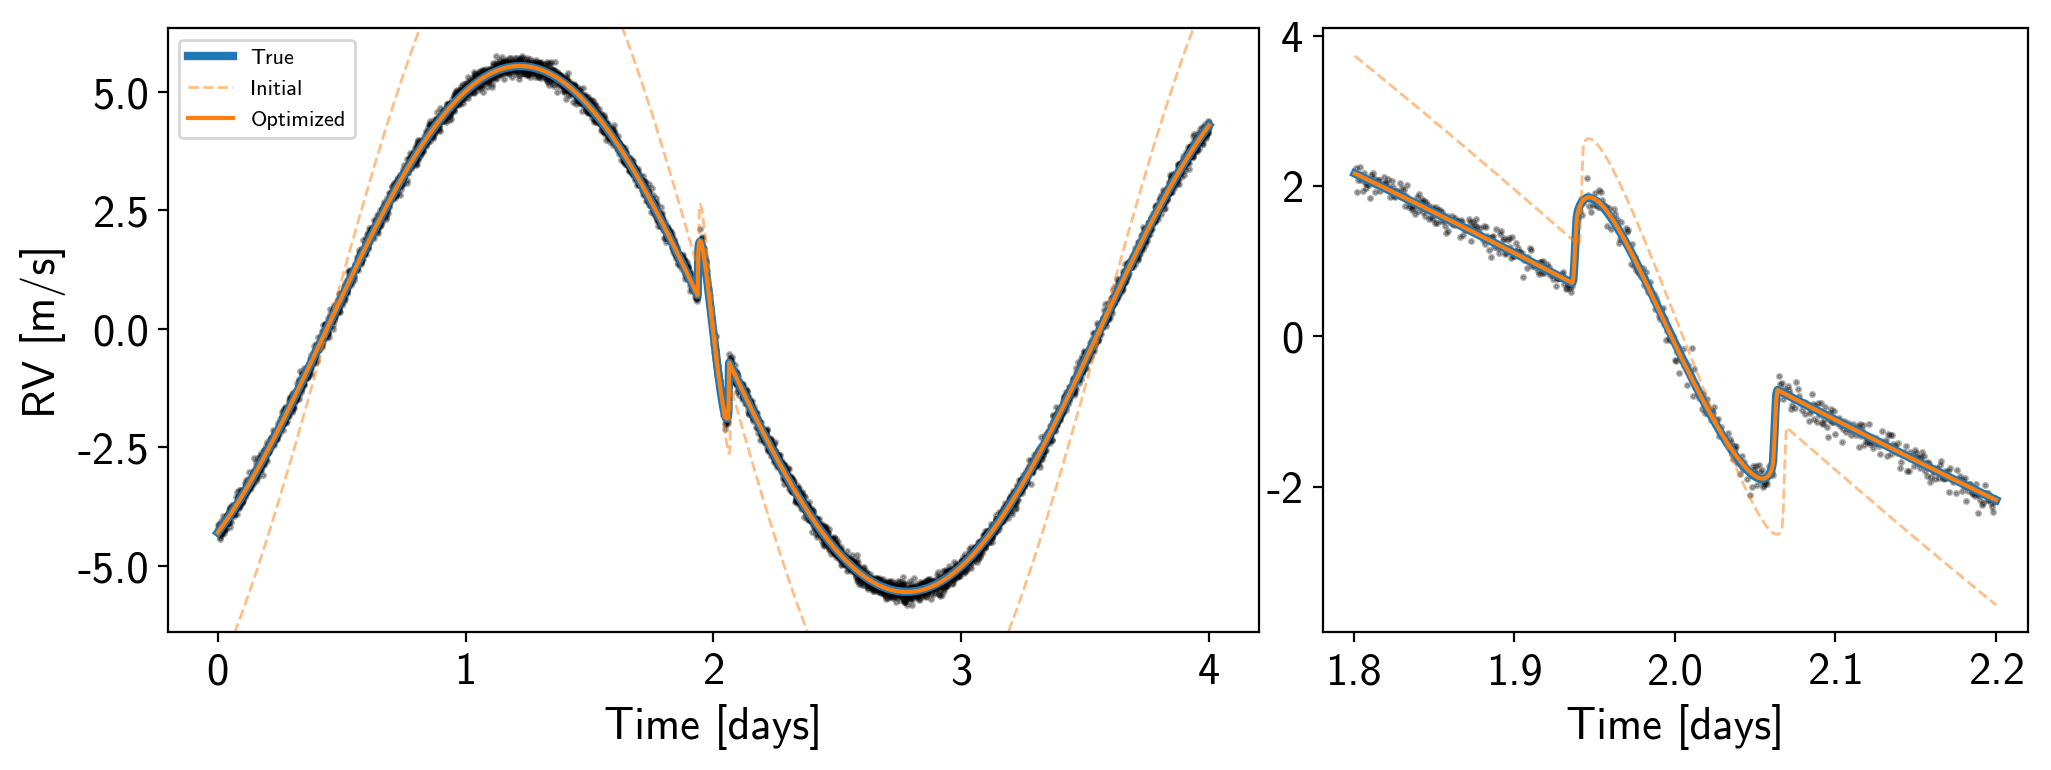

In [8]:
# Plot it
fig = plt.figure(figsize=(12, 4))
ax = [plt.subplot2grid((1, 5), (0, 0), colspan=3),
      plt.subplot2grid((1, 5), (0, 3), colspan=2)]
ax[0].plot(t, rv, 'k.', alpha=0.3, ms=3)
ax[0].set_ylim(*ax[0].get_ylim())
ax[0].plot(t, truths["rv"], "C0-", lw=3, label="True")
ax[0].plot(t, model_guess, "C1--", alpha=0.5, lw=1, label="Initial")
ax[0].plot(t, map_soln["rv_model"], "C1-", label="Optimized")
ax[0].legend(fontsize=8)
ax[0].set_xlabel("Time [days]")
ax[0].set_ylabel("RV [m/s]");
a = np.argmax(t > truths["b_t0"] - 0.2)
b = np.argmax(t > truths["b_t0"] + 0.2)
ax[1].plot(t[a:b], rv[a:b], 'k.', alpha=0.3, ms=3)
ax[1].plot(t[a:b], truths["rv"][a:b], "C0-", lw=3)
ax[1].plot(t[a:b], model_guess[a:b], "C1--", alpha=0.5, lw=1, label="Initial")
ax[1].plot(t[a:b], map_soln["rv_model"][a:b], "C1-", label="Optimized")
ax[1].set_xlabel("Time [days]");

In [ ]:
# Sample it
sampler = exo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains:  39%|███▉      | 2707/6908 [1:18:04<1:19:58,  1.14s/draws]

In [ ]:
varnames = ["A_u", "A_inc", "A_obl", "A_alpha", "A_veq", "A_m", "A_r", 
            "b_period", "b_t0", "b_inc", "b_ecc", "b_w", "b_r", "b_m"]  
pm.summary(trace, varnames=varnames)

In [ ]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);